In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes evaluate unsloth bert-score rouge_score sacrebleu -q

In [1]:
import pandas as pd
import torch
from datasets import Dataset
import evaluate
import time
from tqdm import tqdm
from unsloth import FastLanguageModel

In [3]:
# Preparing datasets
train_path = "/content/MATH_train_staging.csv"
val_path = "/content/MATH_val_staging.csv"
test_path = "/content/MATH_test_staging.csv"

def load_csv_as_dataset(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['question_text', 'answer', 'reasoning'])
    df["prompt"] = df["question_text"].apply(lambda q: f"Question: {q}\n\nReasoning:")
    df["completion"] = df["reasoning"] + "\n\nAnswer: " + df["answer"]
    return Dataset.from_pandas(df[["prompt", "completion"]])

train_ds = load_csv_as_dataset(train_path)
val_ds = load_csv_as_dataset(val_path)
test_df = pd.read_csv(test_path).dropna(subset=['question_text', 'answer', 'reasoning'])

In [4]:
# Loading LLaMA 3.2 Model with Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True
)
FastLanguageModel.for_training(model)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,)

In [5]:
def formatting_prompts_func(example):
    return {'input_ids': tokenizer(f"{example['prompt']}\n{example['completion']}", truncation=True, padding="max_length", max_length=512).input_ids,
            'labels': tokenizer(f"{example['prompt']}\n{example['completion']}", truncation=True, padding="max_length", max_length=512).input_ids}

train_ds = train_ds.map(formatting_prompts_func, remove_columns=["prompt", "completion"])
val_ds = val_ds.map(formatting_prompts_func, remove_columns=["prompt", "completion"])

Map:   0%|          | 0/5988 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

In [6]:
# Fine-tuning with Unsloth-compatible Trainer
from transformers import TrainingArguments
from trl import SFTTrainer
from bitsandbytes.optim import AdamW8bit
from peft import PeftModel, prepare_model_for_kbit_training


if not isinstance(model, PeftModel):
    model = FastLanguageModel.get_peft_model(
        model,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0,
        bias="none",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
    )

training_args = TrainingArguments(
    output_dir="math_llama_unsloth_v1",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=3,  # saving model checkpoint at each epoch
    eval_strategy="epoch", 
    report_to="none",
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    fp16=True
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field=None,
    tokenizer=tokenizer
)

trainer.train()

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 0 MLP layers.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,988 | Num Epochs = 3 | Total steps = 2,244
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-___

Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,0.822500,0.780083
2,0.722500,0.760866


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=2244, training_loss=0.7587753880682688, metrics={'train_runtime': 13258.851, 'train_samples_per_second': 1.355, 'train_steps_per_second': 0.169, 'total_flos': 1.556334233423708e+17, 'train_loss': 0.7587753880682688})

In [22]:
def cot_prompt(question):
    return f"Question: {question}\nLet's think step by step."

def cod_prompt(question):
    return f"Question: {question}\nLet's solve it in short drafts. Keep each step under 5 words."

# Inference Function
def generate_response(prompt, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated = decoded.replace(prompt, "").strip()
    elapsed = time.time() - start_time
    return generated, elapsed, outputs[0].shape[-1]

In [46]:
# Evaluation
from bert_score import score as bert_score
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
chrf = evaluate.load("chrf")
exact_match = evaluate.load("exact_match")
bleu = evaluate.load("bleu")

results = []

def compute_all_metrics(pred, ref):
    scores = {}
    scores["exact_match"] = exact_match.compute(predictions=[pred], references=[ref])["exact_match"]
    scores["bleu"] = bleu.compute(predictions=[pred], references=[[ref]])["bleu"]
    scores["meteor"] = meteor.compute(predictions=[pred], references=[ref])["meteor"]
    scores["chrf"] = chrf.compute(predictions=[pred], references=[ref])["score"]
    scores["rouge"] = rouge.compute(predictions=[pred], references=[ref])
    P, R, F1 = bert_score([pred], [ref], lang="en", verbose=False)
    scores["bertscore_precision"] = P[0].item()
    scores["bertscore_recall"] = R[0].item()
    scores["bertscore_f1"] = F1[0].item()
    return scores

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [47]:
for i, row in tqdm(test_df.sample(20).iterrows(), total=20):
    q = row['question_text']
    gold = row['answer']

    cot_out, cot_time, cot_tokens = generate_response(cot_prompt(q))
    cod_out, cod_time, cod_tokens = generate_response(cod_prompt(q))

    cot_scores = compute_all_metrics(cot_out, gold)
    cod_scores = compute_all_metrics(cod_out, gold)

    result = {
        "question": q,
        "ground_truth": gold,
        "cot_output": cot_out,
        "cod_output": cod_out,
        "cot_tokens": cot_tokens,
        "cod_tokens": cod_tokens,
        "cot_time": cot_time,
        "cod_time": cod_time,
        "cot_em": cot_scores["exact_match"],
        "cod_em": cod_scores["exact_match"],
        "cot_bleu": cot_scores["bleu"],
        "cod_bleu": cod_scores["bleu"],
        "cot_meteor": cot_scores["meteor"],
        "cod_meteor": cod_scores["meteor"],
        "cot_chrf": cot_scores["chrf"],
        "cod_chrf": cod_scores["chrf"],
        "cot_rouge1": cot_scores["rouge"]["rouge1"],
        "cod_rouge1": cod_scores["rouge"]["rouge1"],
        "cot_rougeL": cot_scores["rouge"]["rougeL"],
        "cod_rougeL": cod_scores["rouge"]["rougeL"],
        "cot_bertscore_f1": cot_scores["bertscore_f1"],
        "cod_bertscore_f1": cod_scores["bertscore_f1"],
        "cot_bertscore_precision": cot_scores["bertscore_precision"],
        "cod_bertscore_precision": cod_scores["bertscore_precision"],
        "cot_bertscore_recall": cot_scores["bertscore_recall"],
        "cod_bertscore_recall": cod_scores["bertscore_recall"]
    }
    results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv("cot_cod_unsloth_results_updates.csv", index=False)

  0%|          | 0/20 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▌         | 1/20 [00:46<14:35, 46.08s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-l

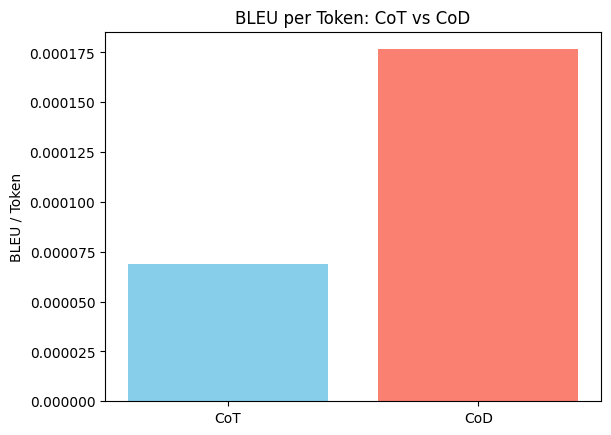

In [40]:
# Visualization
import matplotlib.pyplot as plt

# Token efficiency: BLEU per token
results_df["cot_bleu_per_token"] = results_df["cot_bleu"] / results_df["cot_tokens"]
results_df["cod_bleu_per_token"] = results_df["cod_bleu"] / results_df["cod_tokens"]

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bleu_per_token"].mean(), results_df["cod_bleu_per_token"].mean()], color=["skyblue", "salmon"])
plt.title("BLEU per Token: CoT vs CoD")
plt.ylabel("BLEU / Token")
plt.show()

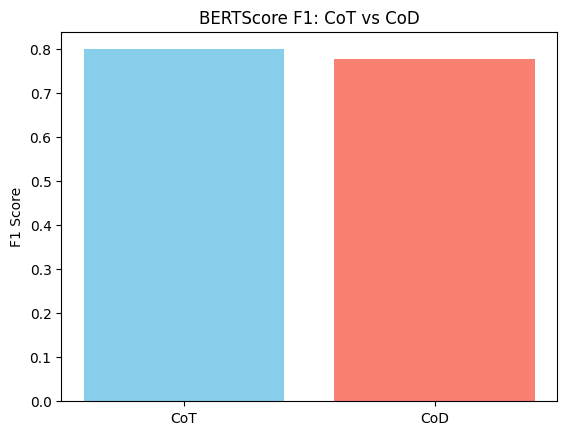

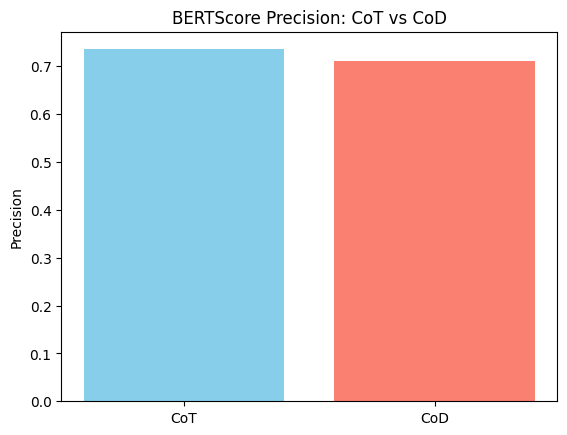

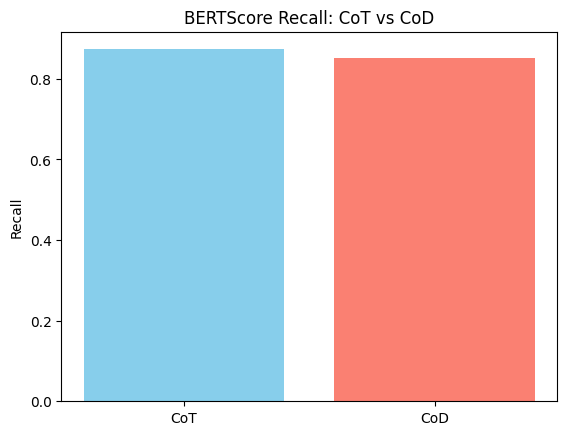

In [48]:
# Precision vs Recall (BERTScore)
plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bertscore_f1"].mean(), results_df["cod_bertscore_f1"].mean()], color=["skyblue", "salmon"])
plt.title("BERTScore F1: CoT vs CoD")
plt.ylabel("F1 Score")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bertscore_precision"].mean(), results_df["cod_bertscore_precision"].mean()], color=["skyblue", "salmon"])
plt.title("BERTScore Precision: CoT vs CoD")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bertscore_recall"].mean(), results_df["cod_bertscore_recall"].mean()], color=["skyblue", "salmon"])
plt.title("BERTScore Recall: CoT vs CoD")
plt.ylabel("Recall")
plt.show()


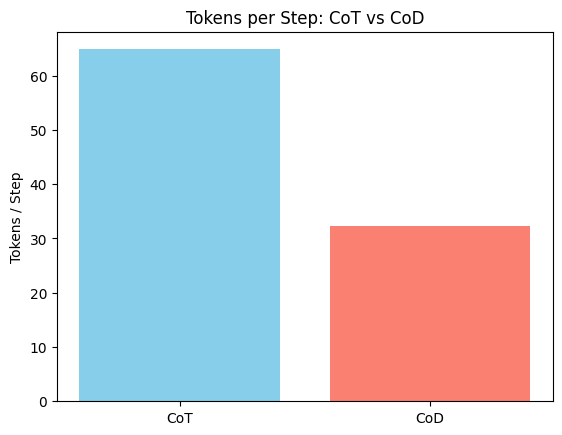

In [42]:
# Tokens per step
results_df["cot_tokens_per_step"] = results_df["cot_tokens"] / (results_df["cot_steps"] + 1)
results_df["cod_tokens_per_step"] = results_df["cod_tokens"] / (results_df["cod_steps"] + 1)

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_tokens_per_step"].mean(), results_df["cod_tokens_per_step"].mean()], color=["skyblue", "salmon"])
plt.title("Tokens per Step: CoT vs CoD")
plt.ylabel("Tokens / Step")
plt.show()

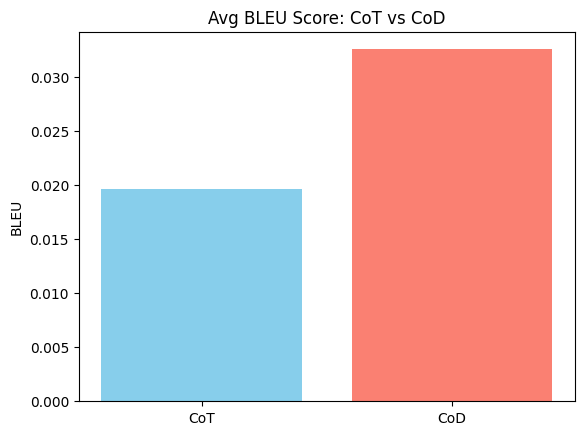

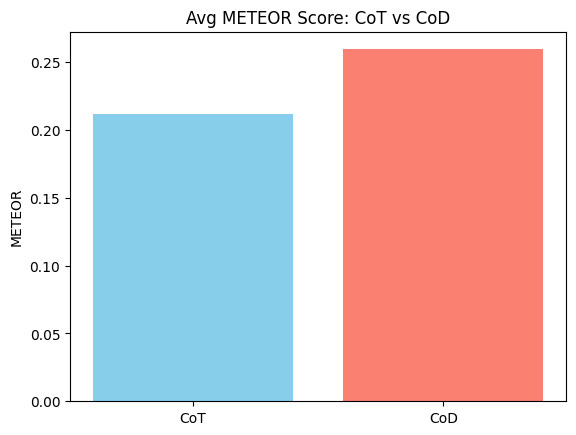

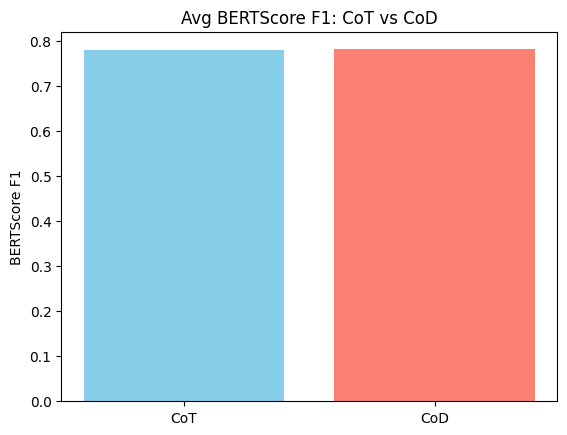

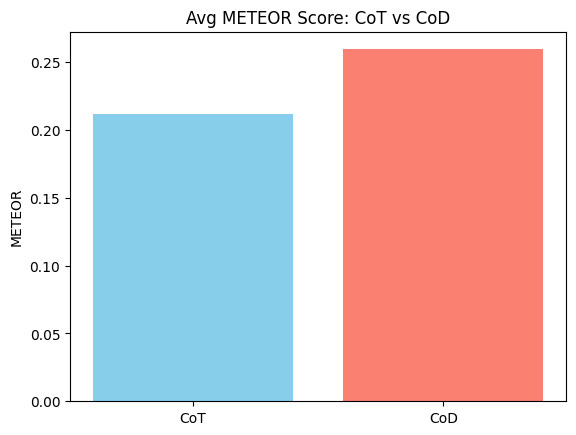

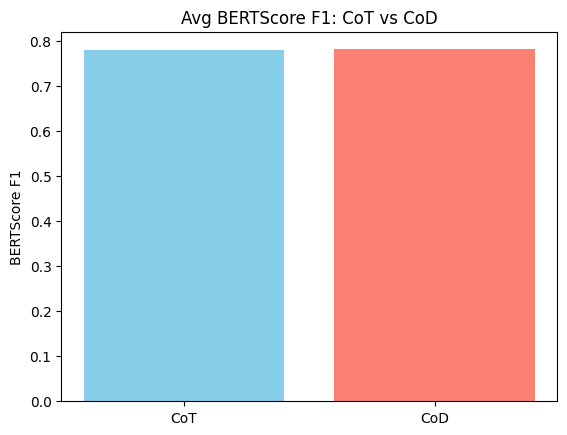

In [44]:
# Steps per output (approx by newline count)
results_df["cot_steps"] = results_df["cot_output"].str.count("")
results_df["cod_steps"] = results_df["cod_output"].str.count("")

# Steps per output (approx by newline count)
results_df["cot_steps"] = results_df["cot_output"].str.count("\n")
results_df["cod_steps"] = results_df["cod_output"].str.count("\n")

# Bar chart: BLEU, METEOR, BERTScore F1 comparison
plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bleu"].mean(), results_df["cod_bleu"].mean()], color=["skyblue", "salmon"])
plt.title("Avg BLEU Score: CoT vs CoD")
plt.ylabel("BLEU")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_meteor"].mean(), results_df["cod_meteor"].mean()], color=["skyblue", "salmon"])
plt.title("Avg METEOR Score: CoT vs CoD")
plt.ylabel("METEOR")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bertscore_f1"].mean(), results_df["cod_bertscore_f1"].mean()], color=["skyblue", "salmon"])
plt.title("Avg BERTScore F1: CoT vs CoD")
plt.ylabel("BERTScore F1")
plt.show()
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_meteor"].mean(), results_df["cod_meteor"].mean()], color=["skyblue", "salmon"])
plt.title("Avg METEOR Score: CoT vs CoD")
plt.ylabel("METEOR")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_bertscore_f1"].mean(), results_df["cod_bertscore_f1"].mean()], color=["skyblue", "salmon"])
plt.title("Avg BERTScore F1: CoT vs CoD")
plt.ylabel("BERTScore F1")
plt.show()

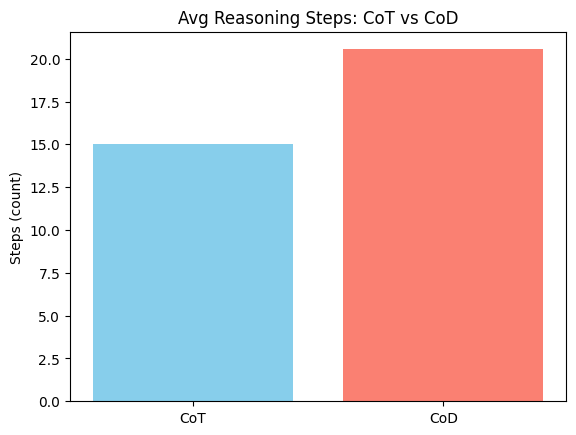

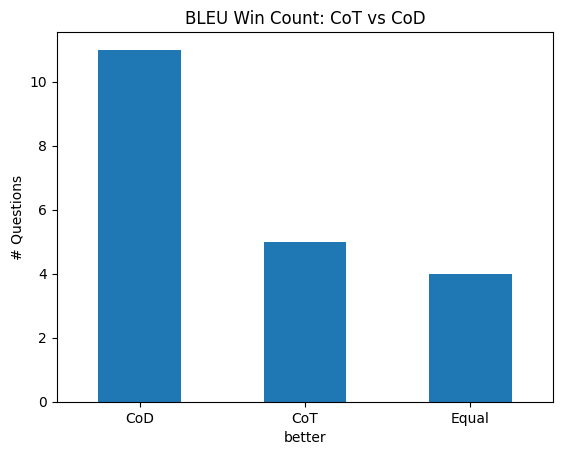

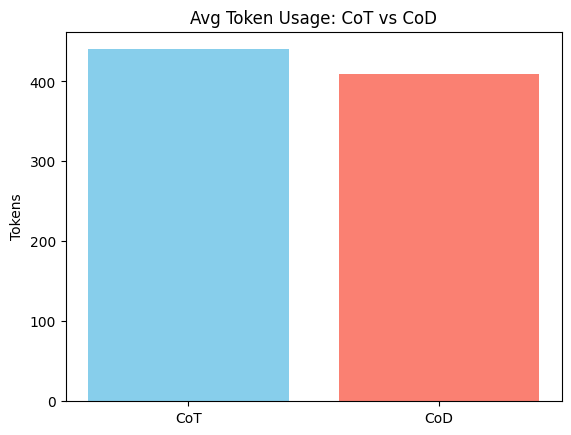

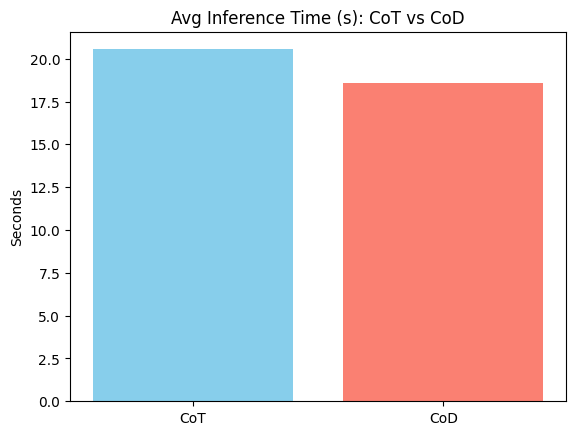

In [45]:
# Step count comparison
plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_steps"].mean(), results_df["cod_steps"].mean()], color=["skyblue", "salmon"])
plt.title("Avg Reasoning Steps: CoT vs CoD")
plt.ylabel("Steps (count)")
plt.show()

# Correctness difference analysis (highlight when CoT or CoD is better)
better_bleu = results_df[["question", "cot_bleu", "cod_bleu"]].copy()
better_bleu["better"] = better_bleu.apply(lambda x: "CoT" if x.cot_bleu > x.cod_bleu else ("CoD" if x.cod_bleu > x.cot_bleu else "Equal"), axis=1)

plt.figure()
better_bleu["better"].value_counts().plot(kind="bar")
plt.title("BLEU Win Count: CoT vs CoD")
plt.ylabel("# Questions")
plt.xticks(rotation=0)
plt.show()
plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_tokens"].mean(), results_df["cod_tokens"].mean()], color=["skyblue", "salmon"])
plt.title("Avg Token Usage: CoT vs CoD")
plt.ylabel("Tokens")
plt.show()

plt.figure()
plt.bar(["CoT", "CoD"], [results_df["cot_time"].mean(), results_df["cod_time"].mean()], color=["skyblue", "salmon"])
plt.title("Avg Inference Time (s): CoT vs CoD")
plt.ylabel("Seconds")
plt.show()

In [ ]:
!pip install huggingface_hub
!pip install transformers
!pip install sentencepiece